# Импорты

In [242]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_log_error

from pathlib import Path
import os
import ast

from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv(), override=True)

import warnings
warnings.filterwarnings('ignore')

# Настройка отображения

In [243]:


sns.set(style="whitegrid")

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

plt.rcParams['figure.figsize'] = (12, 6)
plt.style.use('seaborn-v0_8-darkgrid')

# Загружаем данные

In [244]:
path = Path("../data")

train_df = pd.read_csv(path / 'train.csv')
test_df = pd.read_csv(path / 'test.csv')
sample_submission_df = pd.read_csv(path / 'sampleSubmission.csv')

# EDA

## Общая информация о данных

In [245]:
print("=== TRAIN ===")
print(train_df.info())
print("\n=== TEST ===")
print(test_df.info())
print("\n=== SAMPLE SUBMISSION ===")
print(sample_submission_df.info())

=== TRAIN ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB
None

=== TEST ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    6493 non-null 

## Преобразование datetime и создание признаков времени

In [246]:
# Конвертация datetime
train_df['datetime'] = pd.to_datetime(train_df['datetime'])
test_df['datetime'] = pd.to_datetime(test_df['datetime'])

# Добавим признаки времени
for df in [train_df, test_df]:
    df['year'] = df['datetime'].dt.year
    df['month'] = df['datetime'].dt.month
    df['day'] = df['datetime'].dt.day
    df['hour'] = df['datetime'].dt.hour
    df['weekday'] = df['datetime'].dt.weekday  # 0=Mon, 6=Sun
    df['is_weekend'] = (df['weekday'] >= 5).astype(int)

## Основные статистики

In [247]:
train_df.describe()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,weekday,is_weekend
count,10886,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2011-12-27 05:56:22.399411968,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132,2011.501929,6.521495,9.992559,11.541613,3.013963,0.290557
min,2011-01-01 00:00:00,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000,2011.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,2011-07-02 07:15:00,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000,2011.000000,4.000000,5.000000,6.000000,1.000000,0.000000
50%,2012-01-01 20:30:00,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000,2012.000000,7.000000,10.000000,12.000000,3.000000,0.000000
75%,2012-07-01 12:45:00,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000,2012.000000,10.000000,15.000000,18.000000,5.000000,1.000000
max,2012-12-19 23:00:00,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000,2012.000000,12.000000,19.000000,23.000000,6.000000,1.000000
std,NaN,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454,0.500019,3.444373,5.476608,6.915838,2.004585,0.454040


## Анализ временных паттернов

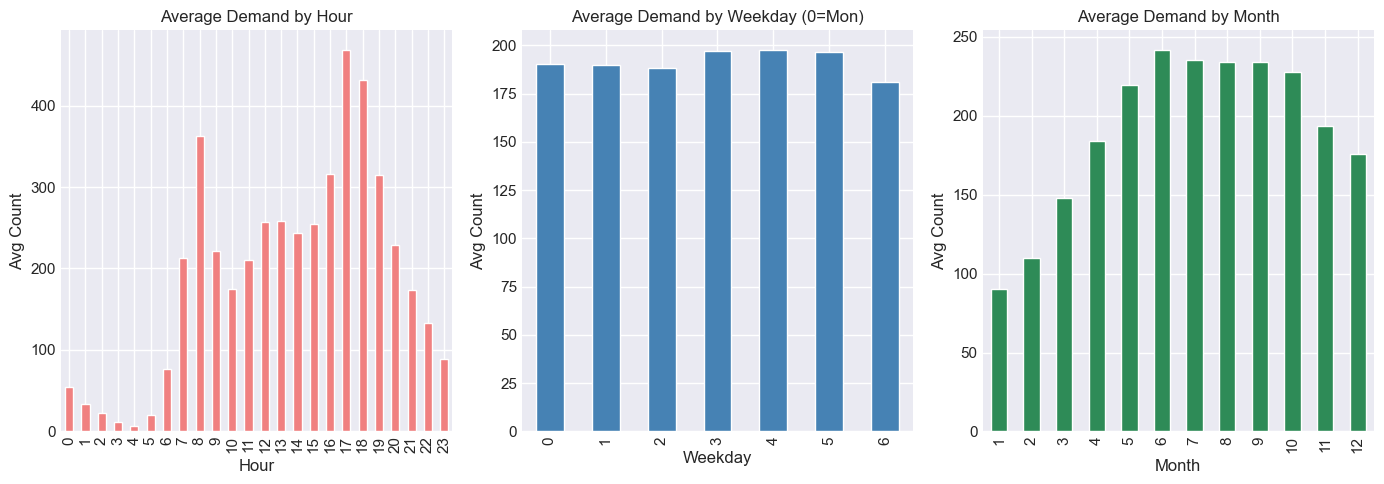

In [248]:
plt.figure(figsize=(14, 5))

# По часам
hourly = train_df.groupby('hour')['count'].mean()
plt.subplot(1, 3, 1)
hourly.plot(kind='bar', color='lightcoral')
plt.title('Average Demand by Hour')
plt.xlabel('Hour'); plt.ylabel('Avg Count')

# По дням недели
weekday = train_df.groupby('weekday')['count'].mean()
plt.subplot(1, 3, 2)
weekday.plot(kind='bar', color='steelblue')
plt.title('Average Demand by Weekday (0=Mon)')
plt.xlabel('Weekday'); plt.ylabel('Avg Count')

# По месяцам
monthly = train_df.groupby('month')['count'].mean()
plt.subplot(1, 3, 3)
monthly.plot(kind='bar', color='seagreen')
plt.title('Average Demand by Month')
plt.xlabel('Month'); plt.ylabel('Avg Count')

plt.tight_layout()
plt.show()

## Анализ категориальных признаков

               mean  count
weather                   
1        205.236791   7192
2        178.955540   2834
3        118.846333    859
4        164.000000      1


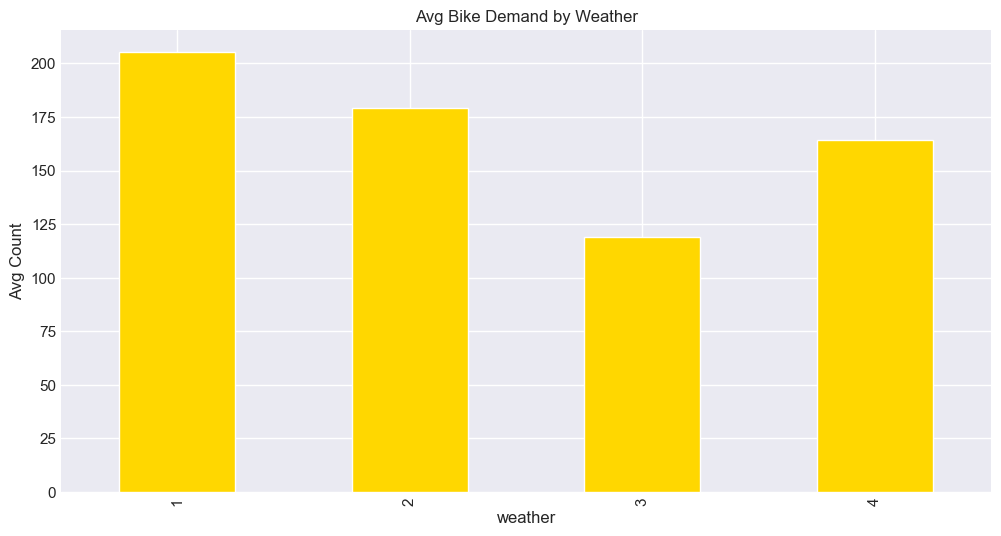

In [249]:
weather_count = train_df.groupby('weather')['count'].agg(['mean', 'count'])
print(weather_count)
# Визуализация
train_df.groupby('weather')['count'].mean().plot(kind='bar', color='gold')
plt.title('Avg Bike Demand by Weather'); plt.ylabel('Avg Count')
plt.show()

## Сезонность 

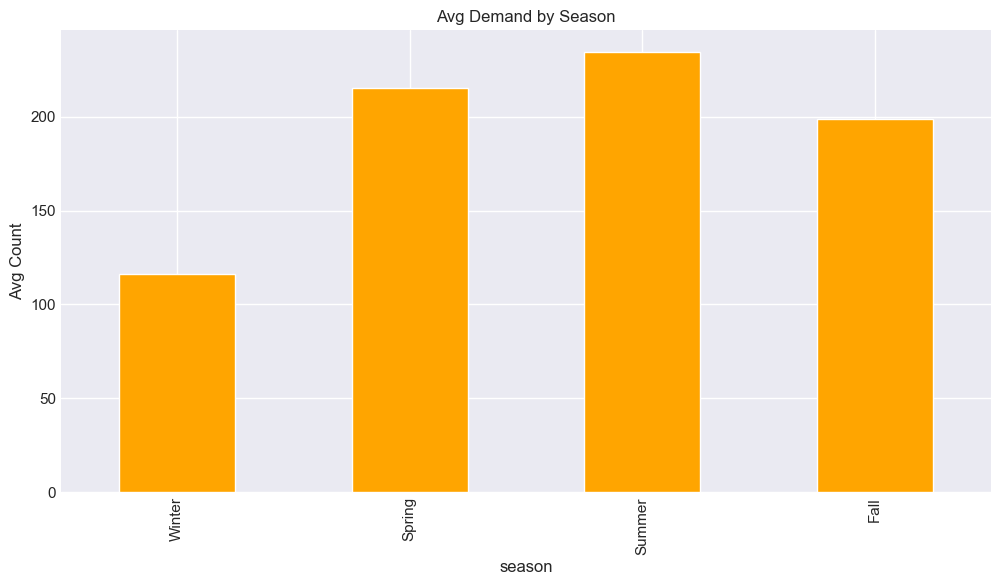

In [250]:
train_df.groupby('season')['count'].mean().plot(kind='bar', color='orange')
plt.title('Avg Demand by Season'); plt.ylabel('Avg Count')
plt.xticks(ticks=[0,1,2,3], labels=['Winter','Spring','Summer','Fall'])
plt.show()

## Распределение целевой переменной

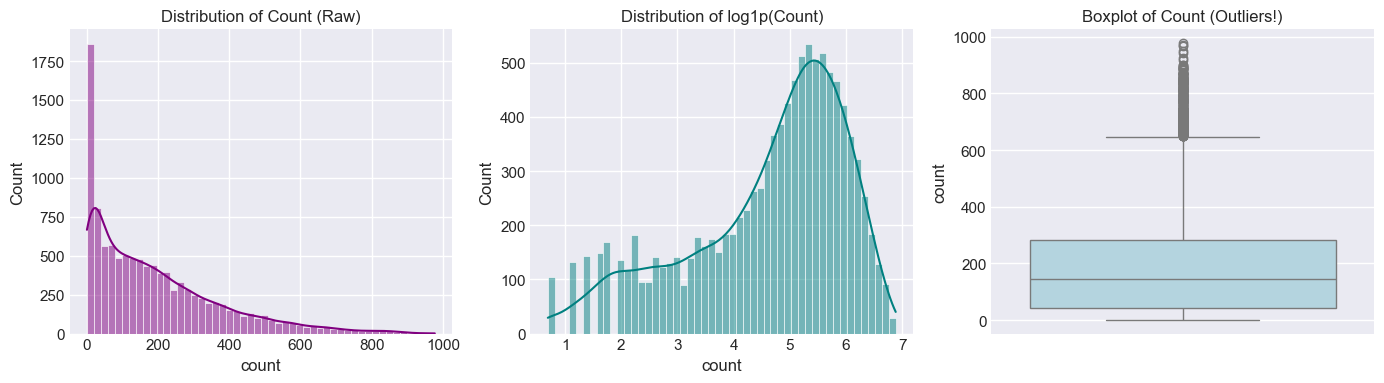

In [251]:
plt.figure(figsize=(14, 4))

plt.subplot(1, 3, 1)
sns.histplot(train_df['count'], kde=True, bins=50, color='purple')
plt.title('Distribution of Count (Raw)')

plt.subplot(1, 3, 2)
sns.histplot(np.log1p(train_df['count']), kde=True, bins=50, color='teal')
plt.title('Distribution of log1p(Count)')

plt.subplot(1, 3, 3)
sns.boxplot(y=train_df['count'], color='lightblue')
plt.title('Boxplot of Count (Outliers!)')

plt.tight_layout()
plt.show()

## Корреляции

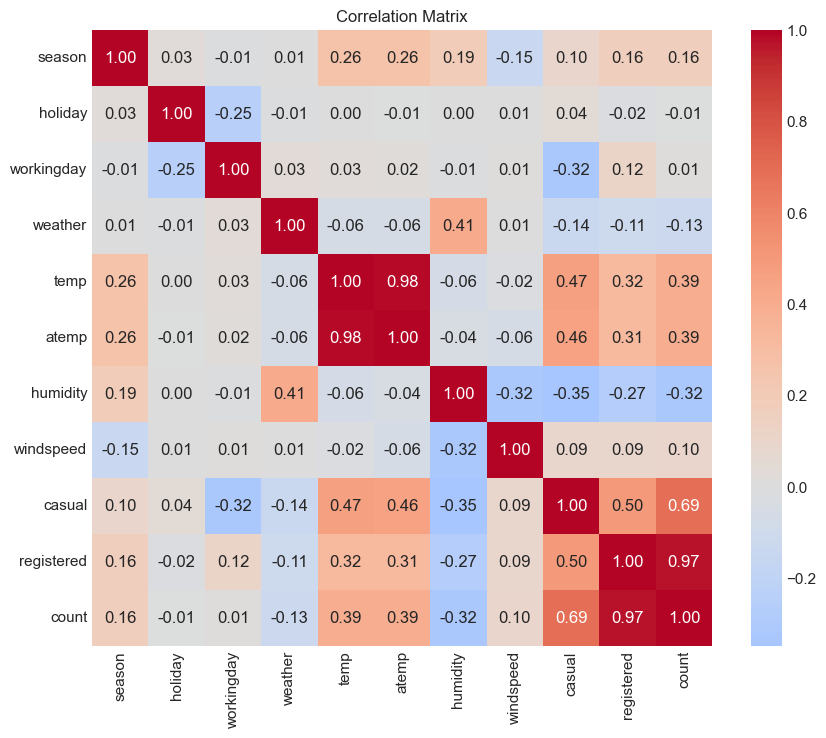

In [252]:
# Выберем числовые признаки + count
num_cols = ['season','holiday','workingday','weather','temp','atemp','humidity','windspeed','casual','registered','count']
corr = train_df[num_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()

## Сравнение train и test (data leakage / shift)

In [253]:
print("Datetime ranges:")
print("Train: ", train_df['datetime'].min(), "->", train_df['datetime'].max())
print("Test:  ", test_df['datetime'].min(), "->", test_df['datetime'].max())

Datetime ranges:
Train:  2011-01-01 00:00:00 -> 2012-12-19 23:00:00
Test:   2011-01-20 00:00:00 -> 2012-12-31 23:00:00


# Функция для добавления признаков

In [254]:
def add_features(df):
    df = df.copy()
    
    # 1. Извлечение временных признаков
    if 'hour' not in df.columns:
        df['hour'] = df['datetime'].dt.hour
        df['weekday'] = df['datetime'].dt.weekday
        df['is_weekend'] = (df['weekday'] >= 5).astype(int)
        df['month'] = df['datetime'].dt.month
    
    # 2. Основные новые признаки
    df['temp_hour'] = df['temp'] * df['hour']
    df['bad_weather'] = (df['weather'] >= 3).astype(int)
    df['peak_hour'] = ((df['hour'].isin([7, 8, 17, 18])) & (df['workingday'] == 1)).astype(int)

    # 3. Дополнительные признаки
    df['season_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['season_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    df['humidity_weather'] = df['humidity'] * df['weather']
    df['workingday_hour'] = df['workingday'] * df['hour']
    
    return df

# Определяем устройство

In [255]:
device_name = os.environ['DEVICE']

if device_name == 'cuda' and not torch.cuda.is_available():
    device_name = 'cpu'

device = torch.device(device_name)
print(f"Используется устройство: {device}")
print(f"Доступно GPU: {torch.cuda.device_count()}")

Используется устройство: cuda
Доступно GPU: 1


# Удаляем избыточные признаки

In [256]:
train_df = add_features(train_df)
test_df = add_features(test_df)

features = [
    'season', 'holiday', 'workingday', 'weather',
    'temp', 'humidity', 'windspeed',
    'hour', 'is_weekend',
    # базовые новые
    'temp_hour', 'bad_weather', 'peak_hour',
    # дополнительные
    'season_sin', 'season_cos',
    'humidity_weather', 'workingday_hour'
]

X = train_df[features].values
y = train_df['count'].values

# Логарифмическая трансформация целевой переменной
y_log = np.log1p(y)

# Стандартизация признаков
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Разделение на train/val
X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y_log, test_size=0.2, random_state=42
)

# Преобразуем в тензоры PyTorch
X_train_tensor = torch.FloatTensor(X_train).to(device)
y_train_tensor = torch.FloatTensor(y_train).view(-1, 1).to(device)
X_val_tensor = torch.FloatTensor(X_val).to(device)
y_val_tensor = torch.FloatTensor(y_val).view(-1, 1).to(device)

# Для теста
X_test = test_df[features].values
X_test_scaled = scaler.transform(X_test)
X_test_tensor = torch.FloatTensor(X_test_scaled)

# Тест корректности признаков

In [257]:
missing_train = set(features) - set(train_df.columns)
assert len(missing_train) == 0, "Не хватает признаков в train"

missing_test = set(features) - set(test_df.columns)
assert len(missing_test) == 0, "Не хватает признаков в test"

# Определение модели PyTorch

In [258]:
class BikeDemandNet(nn.Module):
    def __init__(self, input_size, hidden_sizes=[256, 128, 64], dropout_rate=0.2):
        super(BikeDemandNet, self).__init__()
        layers = []
        prev_size = input_size
        
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(prev_size, hidden_size))
            layers.append(nn.BatchNorm1d(hidden_size))
            layers.append(nn.LeakyReLU(0.1))
            layers.append(nn.Dropout(dropout_rate))
            prev_size = hidden_size
        
        layers.append(nn.Linear(prev_size, 1))
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)

# Обучение с Elastic Net регуляризацией

In [259]:
# Гиперпараметры
hidden_sizes = ast.literal_eval(os.environ['HIDDEN_SIZES'])
dropout_rate = float(os.environ['DROPOUT_RATE'])
epochs = int(os.environ['EPOCHS'])
batch_size = int(os.environ['BATCH_SIZE'])
learning_rate = float(os.environ['LEARNING_RATE'])
weight_decay = float(os.environ['WEIGHT_DECAY'])

# Параметры регуляризации Elastic Net
alpha = float(os.environ['ALPHA'])
l1_ratio = float(os.environ['L1_RATIO'])

input_size = len(features)

# Модель
model = BikeDemandNet(input_size, hidden_sizes, dropout_rate).to(device)
criterion = nn.MSELoss()  # Мы обучаемся на log(count), MSE подходит

optimizer = optim.AdamW(
    model.parameters(), 
    lr=learning_rate, 
    weight_decay=weight_decay
)

# Тренировка
train_losses = []
val_losses = []

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=20)

best_val_loss = float('inf')
patience = 30
trigger_times = 0

for epoch in range(epochs):
    model.train()
    total_loss = 0
    
    # Мини-батчи
    for i in range(0, len(X_train_tensor), batch_size):
        X_batch = X_train_tensor[i:i+batch_size].to(device)
        y_batch = y_train_tensor[i:i+batch_size].to(device)
        
        optimizer.zero_grad()
        
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        
        # Добавляем Elastic Net штраф
        l1_penalty = 0
        l2_penalty = 0
        for param in model.parameters():
            l1_penalty += torch.sum(torch.abs(param))
            l2_penalty += torch.sum(param ** 2)
        
        elastic_penalty = alpha * (l1_ratio * l1_penalty + (1 - l1_ratio) * l2_penalty)
        total_loss_batch = loss + elastic_penalty
        
        total_loss_batch.backward()
        optimizer.step()
        
        total_loss += total_loss_batch.item()
    
    avg_train_loss = total_loss / (len(X_train_tensor) // batch_size + 1)
    train_losses.append(avg_train_loss)
    
    # Валидация
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor).item()
        val_losses.append(val_loss)
    
    if epoch % 50 == 0:
        print(f'Epoch [{epoch}/{epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}')

    scheduler.step(val_loss)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print(f'Early stopping at epoch {epoch}')
            break

Epoch [0/500], Train Loss: 3.6628, Val Loss: 0.6980
Epoch [50/500], Train Loss: 0.6112, Val Loss: 0.3328
Epoch [100/500], Train Loss: 0.5511, Val Loss: 0.2915
Epoch [150/500], Train Loss: 0.5280, Val Loss: 0.2799
Epoch [200/500], Train Loss: 0.5046, Val Loss: 0.2742
Early stopping at epoch 217


# Оценка модели (RMSLE)

In [260]:
# Предсказание на валидации
model.eval()
with torch.no_grad():
    X_val_gpu = X_val_tensor.to(device)
    val_pred_log_gpu = model(X_val_gpu)
    val_pred_log = val_pred_log_gpu.cpu().numpy().flatten()
    
val_pred = np.expm1(val_pred_log)  # обратная трансформация log1p

# RMSLE
def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

rmsle_score = rmsle(np.expm1(y_val), val_pred)
print(f"Validation RMSLE: {rmsle_score:.4f}")

Validation RMSLE: 0.5232


# Предсказание на тесте и сохранение submission

In [261]:
# Предсказание на тесте
model.eval()
with torch.no_grad():
    test_pred_log = model(X_test_tensor.to(device)).cpu().numpy().flatten()
    test_pred = np.expm1(test_pred_log)  # обратно в оригинальный масштаб

# Создание submission
submission = pd.DataFrame({
    'datetime': test_df['datetime'],
    'count': test_pred.clip(0)  # неотрицательные значения
})

# Сохранение
submission.to_csv(path / 'submission_pytorch_elasticnet.csv', index=False)
print("Submission saved!")

Submission saved!


# Визуализация обучения

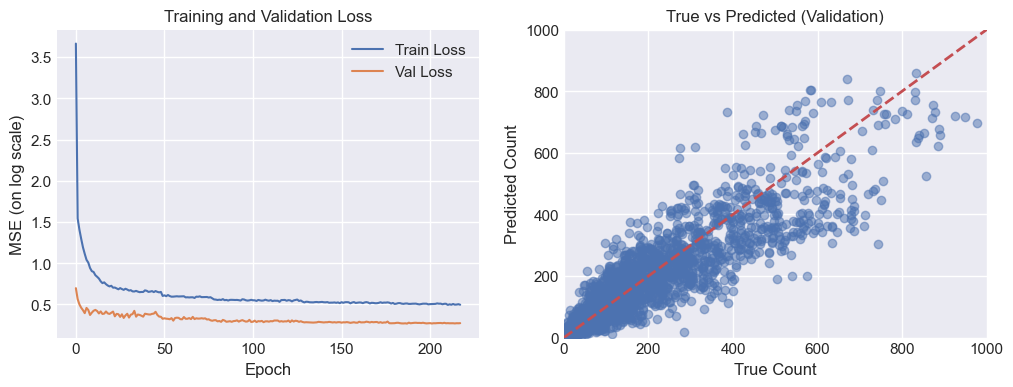

In [262]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE (on log scale)')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(np.expm1(y_val), val_pred, alpha=0.5)
plt.plot([0, 1000], [0, 1000], 'r--', lw=2)
plt.xlabel('True Count')
plt.ylabel('Predicted Count')
plt.title('True vs Predicted (Validation)')
plt.xlim(0, 1000)
plt.ylim(0, 1000)
plt.grid(True)
plt.show()

# Ошибки после обучения

In [263]:
model.eval()
with torch.no_grad():
    val_pred_log = model(X_val_tensor).cpu().numpy().flatten()
    y_val_log = y_val  # это log1p(true_count)

# Обратное преобразование в исходную шкалу
y_val_true = np.expm1(y_val_log)            # истинные значения
y_val_pred = np.expm1(val_pred_log)         # предсказания
y_val_pred = np.clip(y_val_pred, 0, None)   # гарантируем неотрицательность

mask = y_val_true > 0
y_true = y_val_true[mask]
y_pred = y_val_pred[mask]

mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mpe = np.mean((y_pred - y_true) / y_true) * 100

print(f"Validation MAPE: {mape:.2f}%")
print(f"Validation MPE:  {mpe:+.2f}%")

Validation MAPE: 55.28%
Validation MPE:  +26.35%
